## This notebook is part of Hadoop and Spark training delivered by IT-DB group
### SPARK DataFrame Hands-On Lab
_ by Prasanth Kothuri _

### Hands-On 1 - Construct a DataFrame from parquet file
*This demostrates how to read a parquet file and construct a DataFrame*

#### First lets create sparkcontext (sc) and SQLContext (sqlContext)

In [2]:
from pyspark import SparkContext, SQLContext, SparkConf

In [3]:
conf = SparkConf().setMaster("local").set("spark.driver.memory", "1g").set("spark.executor.memory", "1g")

In [4]:
sc = SparkContext(conf = conf)

In [5]:
sqlContext = SQLContext(sc)

#### Read the parquet file into DataFrame

In [6]:
df = sqlContext.read.parquet('../data/UN_Pop_Stats.parquet')

#### Inspect the data

In [7]:
df.show(2)

+-----+-------------+-----+--------+------+---------+-----+------+------+-----------+----------+-------+
|LocID|     Location|VarID| Variant|  Time|MidPeriod|SexID|   Sex|AgeGrp|AgeGrpStart|AgeGrpSpan|  Value|
+-----+-------------+-----+--------+------+---------+-----+------+------+-----------+----------+-------+
|    4|"Afghanistan"|    2|"Medium"|"1950"|   1950.5|    1|"Male"| "0-4"|          0|         5|630.044|
|    4|"Afghanistan"|    2|"Medium"|"1950"|   1950.5|    1|"Male"| "5-9"|          5|         5|516.205|
+-----+-------------+-----+--------+------+---------+-----+------+------+-----------+----------+-------+
only showing top 2 rows



#### Print the schema of the DataFrame

In [8]:
df.printSchema()

root
 |-- LocID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- VarID: string (nullable = true)
 |-- Variant: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- MidPeriod: string (nullable = true)
 |-- SexID: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- AgeGrp: string (nullable = true)
 |-- AgeGrpStart: string (nullable = true)
 |-- AgeGrpSpan: string (nullable = true)
 |-- Value: string (nullable = true)



#### Hands-On 2 - Calculate the year wise population of switzerland
*This shows how to query dataframes and how to show explain plan*

#### first, lets import the bits we need

In [9]:
import pyspark.sql.functions as func

#### year wise population for all countries
*you can see how you can filter, groupBy, aggregate and sort the dataframe*

In [10]:
y_df = df.filter(df.Sex == '"Both"') \
    .groupBy(df.Location,df.Time) \
    .agg(func.sum(df.Value*1000) \
        .alias("Sum")) \
    .orderBy(df.Time)

#### filter out for switzerland (or for that matter your country of choice)
*you can see how select can be used on dataframes to select the columns you need*

In [11]:
c_df = y_df.filter(df.Location == '"Switzerland"') \
    .select(df.Time,"Sum") \
    .collect()

In [12]:
print(c_df)

[Row(Time=u'"1950"', Sum=4668088.0), Row(Time=u'"1955"', Sum=4970810.0), Row(Time=u'"1960"', Sum=5296120.0), Row(Time=u'"1965"', Sum=5829958.0), Row(Time=u'"1970"', Sum=6169357.0), Row(Time=u'"1975"', Sum=6356178.0), Row(Time=u'"1980"', Sum=6303608.0), Row(Time=u'"1985"', Sum=6455680.0), Row(Time=u'"1990"', Sum=6673920.0), Row(Time=u'"1995"', Sum=7017042.0), Row(Time=u'"2000"', Sum=7165581.0), Row(Time=u'"2005"', Sum=7408608.0), Row(Time=u'"2010"', Sum=7830534.0), Row(Time=u'"2015"', Sum=8298663.0), Row(Time=u'"2020"', Sum=8654271.0), Row(Time=u'"2025"', Sum=8951789.0), Row(Time=u'"2030"', Sum=9222938.0), Row(Time=u'"2035"', Sum=9456989.0), Row(Time=u'"2040"', Sum=9660020.0), Row(Time=u'"2045"', Sum=9844509.0), Row(Time=u'"2050"', Sum=10019102.0), Row(Time=u'"2055"', Sum=10172276.0), Row(Time=u'"2060"', Sum=10304082.0), Row(Time=u'"2065"', Sum=10424466.0), Row(Time=u'"2070"', Sum=10542609.0), Row(Time=u'"2075"', Sum=10660384.0), Row(Time=u'"2080"', Sum=10775329.0), Row(Time=u'"2085"', 

#### plot the results using matlibplot

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt

/cvmfs/sft.cern.ch/lcg/releases/matplotlib/1.5.1-763af/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<IPython.core.display.Javascript object>


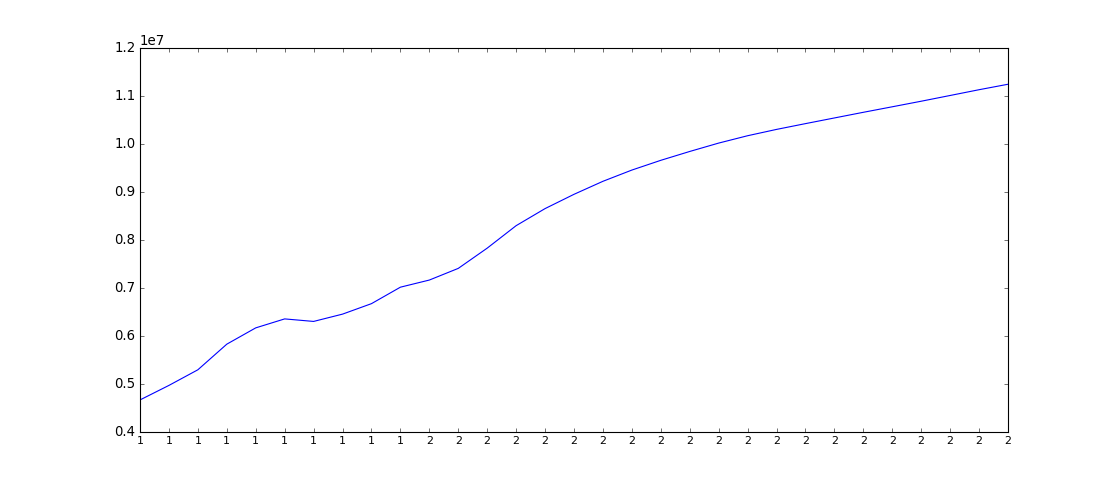

In [31]:
plt.figure(figsize=(14,6))
x_val = [x[0][1] for x in c_df]
y_val = [x[1] for x in c_df]
plt.plot(range(len(y_val)), y_val)
plt.xticks(range(len(x_val)), x_val, size='small')
plt.show()

#### finally you can view the explain plan generated by catalyst optimizer

In [15]:
y_df.explain()

== Physical Plan ==
*Sort [Time#4 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(Time#4 ASC NULLS FIRST, 200)
   +- *HashAggregate(keys=[Location#1, Time#4], functions=[sum((cast(Value#11 as double) * 1000.0))])
      +- Exchange hashpartitioning(Location#1, Time#4, 200)
         +- *HashAggregate(keys=[Location#1, Time#4], functions=[partial_sum((cast(Value#11 as double) * 1000.0))])
            +- *Project [Location#1, Time#4, Value#11]
               +- *Filter (isnotnull(Sex#7) && (Sex#7 = "Both"))
                  +- *FileScan parquet [Location#1,Time#4,Sex#7,Value#11] Batched: true, Format: Parquet, Location: InMemoryFileIndex[file:/eos/user/p/pkothuri/sparkTraining/data/UN_Pop_Stats.parquet], PartitionFilters: [], PushedFilters: [IsNotNull(Sex), EqualTo(Sex,"Both")], ReadSchema: struct<Location:string,Time:string,Sex:string,Value:string>


### Hands-On 3 - This demostrates how DataFrame can be persisted as table and issue queries against it

#### Load the whitehouse vistor records parquet file into DataFrame

In [16]:
wh_df = sqlContext.read.parquet("../data/WH_VR.parquet")

#### Print the schema to understand the layout

In [17]:
wh_df.printSchema()

root
 |-- NAMELAST: string (nullable = true)
 |-- NAMEFIRST: string (nullable = true)
 |-- NAMEMID: string (nullable = true)
 |-- UIN: string (nullable = true)
 |-- BDGNBR: string (nullable = true)
 |-- ACCESS_TYPE: string (nullable = true)
 |-- TOA: string (nullable = true)
 |-- APPT_MADE_DATE: string (nullable = true)
 |-- APPT_START_DATE: date (nullable = true)
 |-- APPT_END_DATE: string (nullable = true)
 |-- APPT_CANCEL_DATE: string (nullable = true)
 |-- Total_People: string (nullable = true)
 |-- LAST_UPDATEDBY: string (nullable = true)
 |-- POST: string (nullable = true)
 |-- LASTENTRYDATE: string (nullable = true)
 |-- TERMINAL_SUFFIX: string (nullable = true)
 |-- visitee_namelast: string (nullable = true)
 |-- visitee_namefirst: string (nullable = true)
 |-- MEETING_LOC: string (nullable = true)
 |-- MEETING_ROOM: string (nullable = true)
 |-- CALLER_NAME_LAST: string (nullable = true)
 |-- CALLER_NAME_FIRST: string (nullable = true)
 |-- description: string (nullable = true

In [19]:
wh_df.columns

['NAMELAST',
 'NAMEFIRST',
 'NAMEMID',
 'UIN',
 'BDGNBR',
 'ACCESS_TYPE',
 'TOA',
 'APPT_MADE_DATE',
 'APPT_START_DATE',
 'APPT_END_DATE',
 'APPT_CANCEL_DATE',
 'Total_People',
 'LAST_UPDATEDBY',
 'POST',
 'LASTENTRYDATE',
 'TERMINAL_SUFFIX',
 'visitee_namelast',
 'visitee_namefirst',
 'MEETING_LOC',
 'MEETING_ROOM',
 'CALLER_NAME_LAST',
 'CALLER_NAME_FIRST',
 'description',
 'RELEASE_DATE']

#### Inspect the data

In [20]:
wh_df.select("NAMELAST","APPT_START_DATE").show(10)

+-----------+---------------+
|   NAMELAST|APPT_START_DATE|
+-----------+---------------+
|Adamopoulos|           null|
|    Brosman|           null|
|  Brumfield|           null|
|    Chipman|           null|
|      Chubb|           null|
|  Colasante|           null|
|     Conway|           null|
|        Cox|           null|
|     Curtis|           null|
|        Day|           null|
+-----------+---------------+
only showing top 10 rows



#### persist the DataFrame as temporary table

In [21]:
wh_df.registerTempTable("Vistor_Records")

#### You can now use issue the queries against this table using sqlContext.sql interface
*Count the vistors by last name*

In [22]:
count_by_name = sqlContext.sql("select NAMELAST, count(1) as count from Vistor_Records group by NAMELAST order by count desc")

In [23]:
count_by_name.show()

+--------+-----+
|NAMELAST|count|
+--------+-----+
|   Smith|25908|
| Johnson|21491|
|Williams|18228|
|   Brown|16804|
|   Jones|16023|
|   SMITH|14565|
|  Miller|12942|
|   Davis|12263|
| JOHNSON|12157|
|     Lee|10151|
|WILLIAMS|10147|
|   BROWN| 9847|
|   JONES| 9269|
|Anderson| 9064|
|  Thomas| 8779|
|  Wilson| 8604|
|  Taylor| 8242|
| Jackson| 8146|
|Thompson| 7911|
|   Moore| 7855|
+--------+-----+
only showing top 20 rows



*count the number of vistors by year*

In [24]:
count_by_day = sqlContext.sql("select year(APPT_START_DATE), count(1) as count from Vistor_Records \
    where APPT_START_DATE is not null \
    group by year(APPT_START_DATE) \
    order by year(APPT_START_DATE)").collect()

<IPython.core.display.Javascript object>


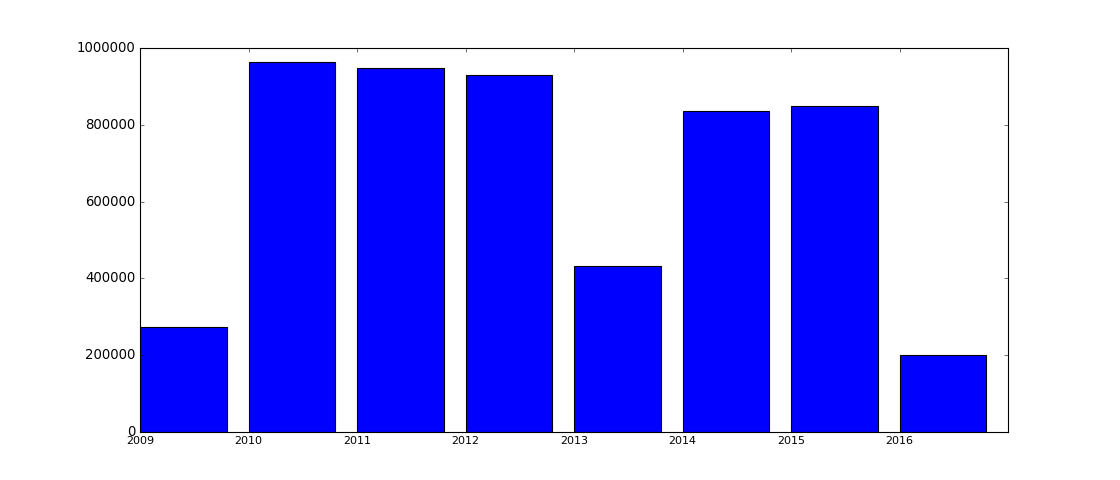

In [25]:
plt.figure(figsize=(14,6))
x_val = [x[0] for x in sorted(count_by_day)]
y_val = [x[1] for x in sorted(count_by_day)]
plt.bar(range(len(y_val)), y_val)
plt.xticks(range(len(x_val)), x_val, size='small')
plt.show()

#### Count the number of vistors by weekday
*This demonstrates how you can create UDF - user defined function*

In [26]:
from datetime import datetime
from pyspark.sql.types import StringType
def get_weekday(str):
    return str.strftime("%A")
sqlContext.registerFunction("get_weekday", lambda x: \
                            get_weekday(x), \
                            StringType())

In [27]:
count_by_wday = sqlContext.sql("select get_weekday(APPT_START_DATE), count(1) as count from Vistor_Records \
    where APPT_START_DATE is not null \
    group by get_weekday(APPT_START_DATE) \
    order by count desc")

In [28]:
count_by_wday.show()

+----------------------------+-------+
|get_weekday(APPT_START_DATE)|  count|
+----------------------------+-------+
|                      Friday|1099089|
|                    Saturday|1039378|
|                     Tuesday| 944460|
|                    Thursday| 912308|
|                   Wednesday| 902502|
|                      Monday| 362049|
|                      Sunday| 172281|
+----------------------------+-------+



#### Finally lets produce histogram on the group size

In [29]:
group_size = sqlContext.sql("select distinct UIN, Total_People from Vistor_Records \
    where Total_People > 30 \
    and Total_People < 200").collect()

<IPython.core.display.Javascript object>


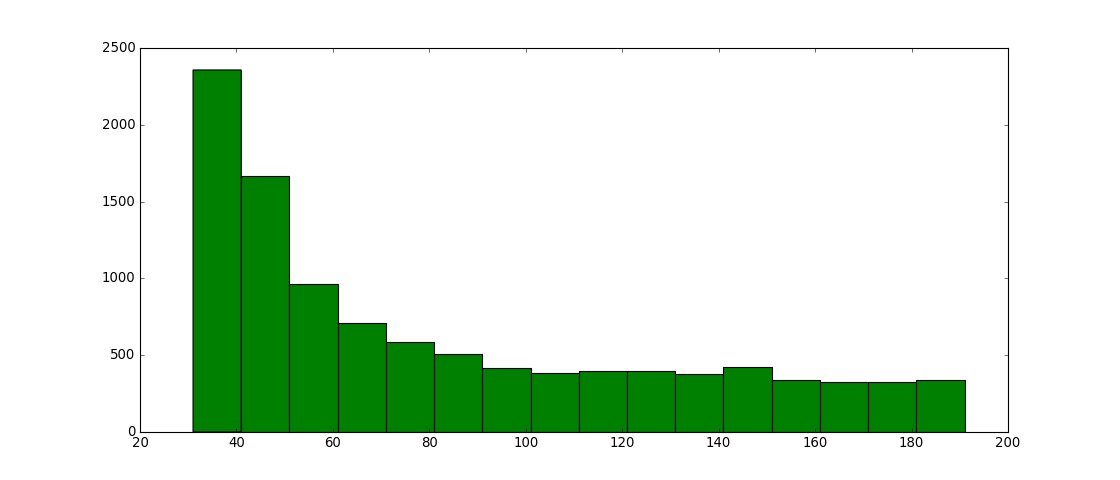

31 199


In [30]:
import numpy as np
plt.figure(figsize=(14,6))
x_val = [int(x[1]) for x in group_size]
print min(x_val),max(x_val)
bins = np.arange(min(x_val), max(x_val), 10) 
n, bins, patches = plt.hist(x_val, bins=bins, facecolor='green')

### Hands-On 4 - Construct the dataframes using json
*This demonstrates how json can be manipulated using dataframes*

#### Read a json into a dataframe

In [ ]:
df_json = sqlContext.read.json('/eos/user/p/pkothuri/hadoop-tutorials-data/meetup-final.json')

#### dataframe can infer schema from json file

In [ ]:
df_json.printSchema()

#### Top events by rsvp's

In [ ]:
df_json.groupBy(df_json.event.event_name,df_json.group.group_city,df_json.venue.venue_name) \
    .count() \
    .orderBy("count", ascending = False) \
    .show()

#### what if the json contains an array, no problem we can explode it

In [ ]:
from pyspark.sql.functions import explode

In [ ]:
df_json.select(df_json.event.event_name,explode("group.group_topics")).show()